<a href="https://colab.research.google.com/github/jongbokhi/Time-Series_model/blob/master/Exchange_rate_using_Darts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install darts

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import darts
import datetime
import yfinance as yf
import sys
import numbers
import time
import math
import matplotlib.pyplot as plt

from functools import reduce
# multiprocessing
from joblib import Parallel, delayed

# data manipulation
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# transformers and preprocessing
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller

# models
from darts.models import NaiveSeasonal, NaiveDrift, StatsForecastAutoARIMA, ARIMA, AutoARIMA, Theta, ExponentialSmoothing, Prophet #local
from darts.models import XGBModel, LightGBMModel, CatBoostModel, RNNModel, NBEATSModel, BlockRNNModel, TFTModel #global
  
# likelihood
from darts.utils.likelihood_models import GaussianLikelihood

# evaluation
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox


# settings
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

#Preapare Datasets

In [ ]:
effective_rate_df = pd.read_csv('/content/drive/MyDrive/RIFSPFFNB.csv')

effective_rate_df = effective_rate_df.set_index('DATE')

effective_rate_df.index = pd.to_datetime(effective_rate_df.index)

In [ ]:
effective_rate_series = TimeSeries.from_dataframe(effective_rate_df, fill_missing_dates=True, freq='d')

In [ ]:
effective_rate_series

<TimeSeries (DataArray) (DATE: 4684, component: 1, sample: 1)>
array([[[0.17]],

       [[0.18]],

       [[ nan]],

       ...,

       [[4.83]],

       [[4.83]],

       [[4.83]]])
Coordinates:
  * DATE       (DATE) datetime64[ns] 2010-07-01 2010-07-02 ... 2023-04-27
  * component  (component) object 'RIFSPFFNB'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
#load data from Yahoo Finance

tesla = yf.Ticker("TSLA")
brent= yf.Ticker("BZ=F")
wti= yf.Ticker("CL=F")
usd=yf.Ticker("KRW=X")

# get historical market data

start_date = datetime.date(2010, 7, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")
end_date= datetime.date(2023, 4, 28)

teslas_hist = tesla.history(start= start_date, end= end_date)
brent_crude_oil =brent.history(start= start_date, end= end_date)
wti_crude_oil =wti.history(start= start_date, end= end_date)
usd_kwon=usd.history(start= start_date, end= end_date)

In [ ]:
tesla_open = teslas_hist['Open']
brent_open = brent_crude_oil['Open']
wti_open = wti_crude_oil['Open']
usd_kwon_open = usd_kwon['Open']

In [ ]:
tesla_open_df= teslas_hist['Open'].to_frame()
brent_open_df= brent_crude_oil['Open'].to_frame()
wti_open_df= wti_crude_oil['Open'].to_frame()
usd_kwon_df= usd_kwon['Open'].to_frame()

In [ ]:
# unifiy timezone of timeindex for merging dataframes

tesla_open_df.index = tesla_open_df.index.tz_localize(None)
brent_open_df.index = brent_open_df.index.tz_localize(None)
wti_open_df.index = wti_open_df.index.tz_localize(None)
usd_kwon_df.index = usd_kwon_df.index.tz_localize(None)

In [ ]:
tesla_open = TimeSeries.from_dataframe(tesla_open_df, fill_missing_dates=True, freq='d')
brent_open = TimeSeries.from_dataframe(brent_open_df, fill_missing_dates=True, freq='d')
wti_open = TimeSeries.from_dataframe(wti_open_df, fill_missing_dates=True, freq='d')
usd_kwon_open = TimeSeries.from_dataframe(usd_kwon_df, fill_missing_dates=True, freq='d')


In [ ]:
tesla_open

<TimeSeries (DataArray) (Date: 4684, component: 1, sample: 1)>
array([[[  1.66666698]],

       [[  1.53333294]],

       [[         nan]],

       ...,

       [[159.82000732]],

       [[160.28999329]],

       [[152.63999939]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2010-07-01 2010-07-02 ... 2023-04-27
  * component  (component) object 'Open'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
#Treat Missing Values
filler = MissingValuesFiller()

tesla_open = filler.transform(tesla_open, method="quadratic")

brent_open = filler.transform(brent_open, method="quadratic")

wti_open = filler.transform(wti_open, method="quadratic")

usd_kwon_open = filler.transform(usd_kwon_open, method="quadratic")

effective_rate_series = filler.transform(effective_rate_series, method="quadratic")

# Local Models: Single Timeseries 


*   AutoARIMA
*   ExponentialSmoothing
*   NaiveDrift
*   Theta
*   Prophet



In [ ]:
# check for seasonality, via ACF

for m in range(2, 25):
    is_seasonal, mseas = check_seasonality(usd_kwon_open, m=m, alpha=0.05)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {}.'.format(mseas))

seasonal? False


In [ ]:
usd_kwon_open[:-1212]

<TimeSeries (DataArray) (Date: 3472, component: 1, sample: 1)>
array([[[1226.90002441]],

       [[1223.19995117]],

       [[1211.74848575]],

       ...,

       [[1158.70996094]],

       [[1156.33996582]],

       [[1154.40002441]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2010-07-01 2010-07-02 ... 2020-01-01
  * component  (component) object 'Open'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

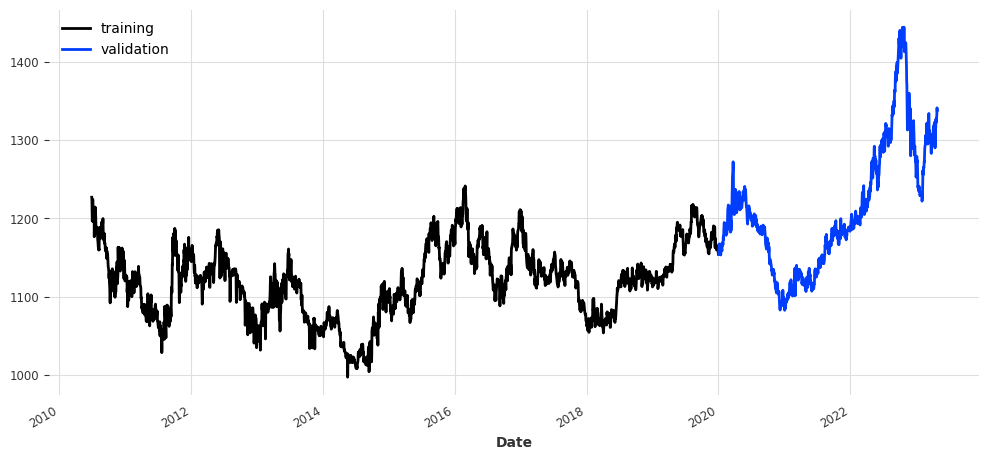

In [ ]:
## split train and test data

train, val = usd_kwon_open[:-1212], usd_kwon_open[-1212:]

plt.figure(101, figsize=(12, 5))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

# Define the function

  *Fitting

  *Prediction

  *Accuracy metrics

In [ ]:
## fit the chosen forecaster model and compute predictions

def eval_model(model):
    t_start =  time.perf_counter()
    print("beginning: " + str(model))


    # fit the model and compute predictions
    res = model.fit(train)
    forecast = model.predict(len(val))

    # for naive forecast, concatenate seasonal fc with drift fc
    if model == m_naive:
        if is_seasonal:
            fc_drift = forecast
            modelS = NaiveSeasonal(K=12)
            modelS.fit(train)
            fc_seas = modelS.predict(len(val))
            forecast = fc_drift + fc_seas - train.last_value()


    # compute accuracy metrics and processing time
    res_mape = mape(val, forecast)
    res_mae = mae(val, forecast)
    res_r2 = r2_score(val, forecast)
    res_rmse = rmse(val, forecast)
    res_rmsle = rmsle(val, forecast)
    res_time = time.perf_counter() - t_start
    res_accuracy = {"MAPE":res_mape, "MAE":res_mae, "R squared":-res_r2, "RMSE":res_rmse, "RMSLE":res_rmsle, "time":res_time}

    results = [forecast, res_accuracy]
    print("completed: " + str(model) + ":" + str(res_time) + "sec")
    return results


# Definition: Local models

In [ ]:
#1.Naïve model
m_naive = NaiveDrift()

#2.Exponential Smoothing
if is_seasonal:
    m_expon = ExponentialSmoothing(seasonal_periods=mseas)
else:
    m_expon = ExponentialSmoothing()

#3.Prophet
m_prophet = Prophet() 


In [ ]:
#4.prepare ARIMA 
import pmdarima as pmd

y = np.asarray(usd_kwon_open.pd_series())

# get order of first differencing: the higher of KPSS and ADF test results
n_kpss = pmd.arima.ndiffs(y, alpha=0.05, test='kpss', max_d=2)
n_adf = pmd.arima.ndiffs(y, alpha=0.05, test='adf', max_d=2)
n_diff = max(n_adf, n_kpss)

# get order of seasonal differencing: the higher of OCSB and CH test results
n_ocsb = pmd.arima.OCSBTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y)
n_ch = pmd.arima.CHTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y)
ns_diff = max(n_ocsb, n_ch, is_seasonal * 1)

# set up ARIMA 
m_arima = AutoARIMA(
    start_p=1, d=n_diff, start_q=1,
    max_p=4, max_d=n_diff, max_q=4,
    start_P=0, D=ns_diff, start_Q=0, m=max(4,mseas), seasonal=is_seasonal,
    max_P=3, max_D=1, max_Q=3,
    max_order=5,                       # p+q+p+Q <= max_order
    stationary=False, 
    information_criterion="bic", alpha=0.05, 
    test="kpss", seasonal_test="ocsb",
    stepwise=True, 
    suppress_warnings=True, error_action="trace", trace=True, with_intercept="auto")

In [ ]:
#5. prepare Theta 

# search space for best theta value: check 100 alternatives

thetas = 2 - np.linspace(-10, 10, 100)

# initialize search

best_mape = float('inf')
best_theta = 0

# search for best theta among 50 values, as measured by MAPE
for theta in thetas:
    model = Theta(theta)
    res = model.fit(train)
    pred_theta = model.predict(len(val))
    res_mape = mape(val, pred_theta)

    if res_mape < best_mape:
        best_mape = res_mape
        best_theta = theta

m_theta = Theta(best_theta)   # best theta model among 100

# Prediction: Local models 

In [ ]:
# forecasters to run

models = [ 
    m_expon, 
    m_theta, 
    m_arima,
    m_naive, 
    m_prophet]

In [ ]:
# Model_Prediction
model_predictions = [eval_model(model) for model in models]

beginning: ExponentialSmoothing()
completed: ExponentialSmoothing():0.8024708940000096sec
beginning: Theta(theta=-0.1212121212121211)
completed: Theta(theta=-0.1212121212121211):0.1455942210000103sec
beginning: AutoARIMA(start_p=1, d=1, start_q=1, max_p=4, max_d=1, max_q=4, start_P=0, D=0, start_Q=0, m=4, seasonal=False, max_P=3, max_D=1, max_Q=3, max_order=5, stationary=False, information_criterion=bic, alpha=0.05, test=kpss, seasonal_test=ocsb, stepwise=True, suppress_warnings=True, error_action=trace, trace=True, with_intercept=auto)
Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=22621.260, Time=3.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=22751.896, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=22723.947, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=22690.914, Time=1.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=22743.781, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=22502.418, Time=1.79 sec
 ARIMA(2,1,0

In [ ]:
#Accuracy of Models
#Green is Best model
#Yellow is Worst model 

df_acc = pd.DataFrame.from_dict(model_predictions[0][1], orient="index")
df_acc.columns = [models[0].__class__.__name__]

for i, m in enumerate(models):
    if i > 0: 
        df = pd.DataFrame.from_dict(model_predictions[i][1], orient="index")
        df.columns = [m.__class__.__name__]
        df_acc = pd.concat([df_acc, df], axis=1)
    i +=1

pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)


,ExponentialSmoothing,Theta,AutoARIMA,NaiveDrift,Prophet
MAPE,31.484891,4.459133,5.926078,6.574713,8.594073
MAE,393.253833,54.886146,75.223053,83.709512,101.677509
R squared,32.006066,-0.318234,0.495317,0.870119,1.006009
RMSE,468.144158,67.282248,99.643603,111.433912,115.411512
RMSLE,0.512529,0.054251,0.080453,0.090759,0.093119
time,0.802471,0.145594,90.780173,0.096834,3.935112


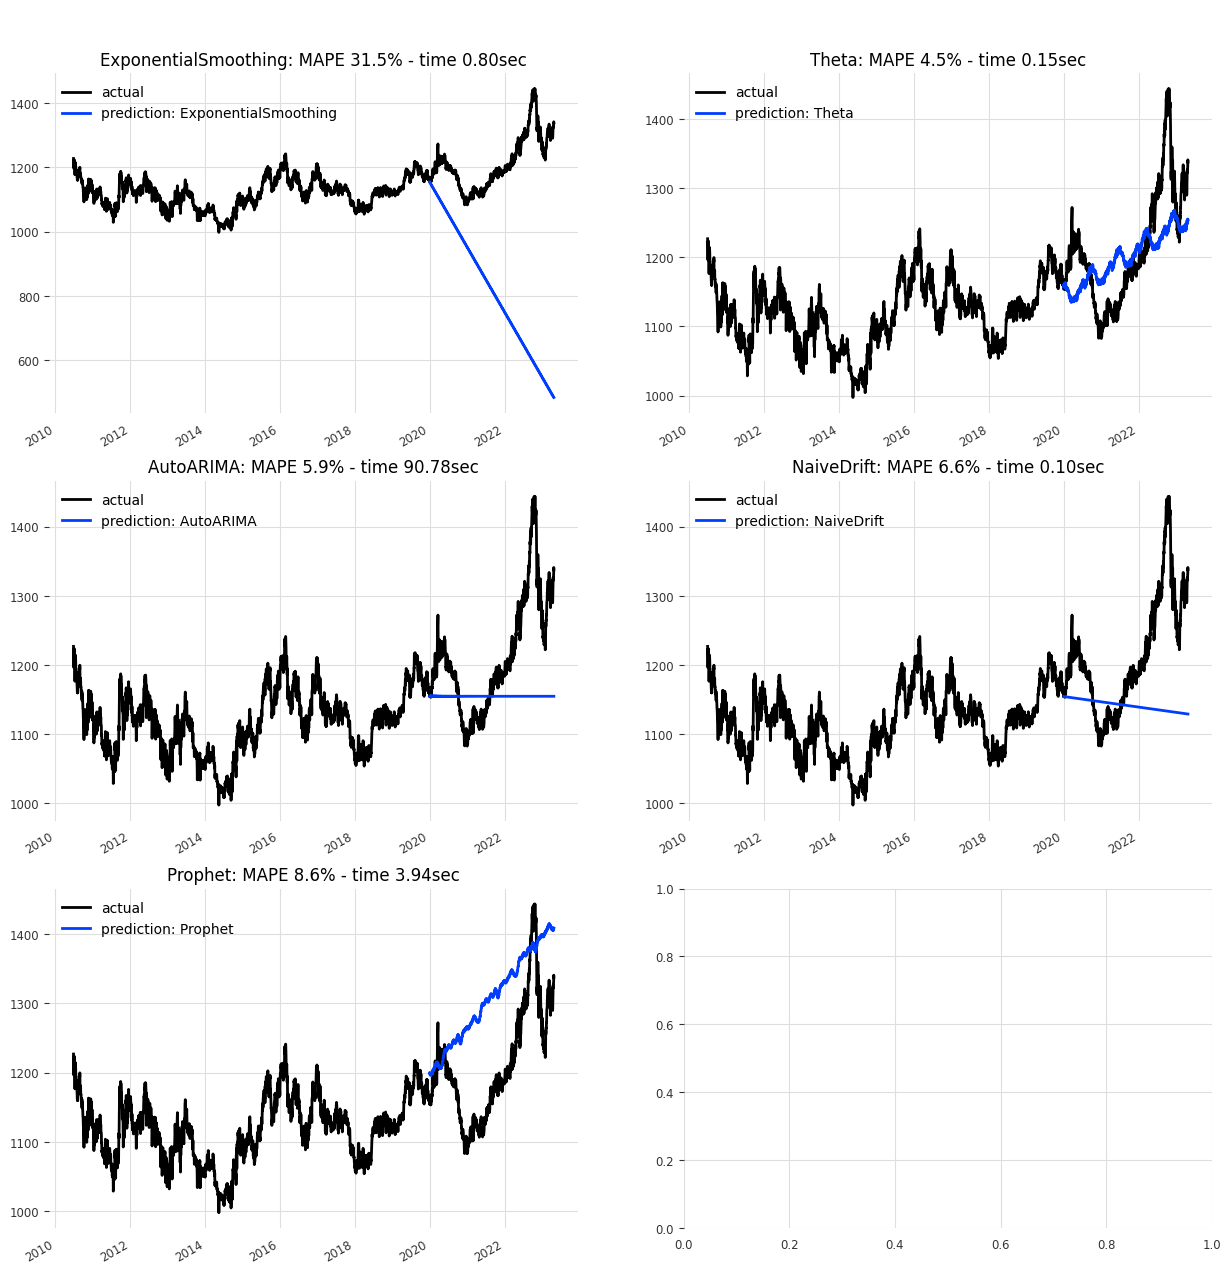

In [ ]:
# plot the forecasts

pairs = math.ceil(len(models)/2)                    # how many rows of charts
fig, ax = plt.subplots(pairs, 2, figsize=(15, 5 * pairs))
ax = ax.ravel()

for i,m in enumerate(models):
        usd_kwon_open.plot(label="actual", ax=ax[i])
        model_predictions[i][0].plot(label="prediction: "+str(m.__class__.__name__), ax=ax[i])
        
        mape_model =  model_predictions[i][1]["MAPE"]
        time_model =  model_predictions[i][1]["time"]
        ax[i].set_title("\n\n" + str(m.__class__.__name__) + ": MAPE {:.1f}%".format(mape_model) + " - time {:.2f}sec".format(time_model))

        ax[i].set_xlabel("")
        ax[i].legend()

##Diagnostics of Residuals

* the presence of **autocorrelation** in the **residuals** of a time series model

  1.   **P-value >** significance level(alpha): **White Noise** 
  2.   P-value < significance level(alpha): the evidence of **autocorrelation** 
       in the residual

* Normality test 

   even if the residuals do not follow a normal distribution, it does not necessarily mean that the model is incorrect or that the forecast results are invalid.

1.   **P-value >** significance level(alpha):**normally **distributed
2.   P-value < significance level(alpha): **not normally** distributed



In [ ]:
##Diagnostics of Residuals
import statsmodels.api as sm 
from darts.dataprocessing.transformers.boxcox import BoxCox
from scipy.stats import normaltest

act = val

resL = {}
resN = {} 
for i,m in enumerate(models):
        pred = model_predictions[i][0]
        resid = pred - act
        sr = resid.pd_series() 

        resL[str(m)] = sm.stats.acorr_ljungbox(sr, lags=[5], return_df=False)[1][0]
        resN[str(m)] = normaltest(sr)[1]

        
print("\nLjung-Box test for white-noise residuals: p-value > alpha?")
[print(key,":",value) for key,value in resL.items()]

print("\ntest for normality of residuals: p-value > alpha?")
[print(key,":",value) for key,value in resN.items()]


Ljung-Box test for white-noise residuals: p-value > alpha?
ExponentialSmoothing() : 0.0
Theta(theta=-0.1212121212121211) : 0.0
AutoARIMA(start_p=1, d=1, start_q=1, max_p=4, max_d=1, max_q=4, start_P=0, D=0, start_Q=0, m=4, seasonal=False, max_P=3, max_D=1, max_Q=3, max_order=5, stationary=False, information_criterion=bic, alpha=0.05, test=kpss, seasonal_test=ocsb, stepwise=True, suppress_warnings=True, error_action=trace, trace=True, with_intercept=auto) : 0.0
NaiveDrift() : 0.0
Prophet() : 0.0

test for normality of residuals: p-value > alpha?
ExponentialSmoothing() : 0.0
Theta(theta=-0.1212121212121211) : 1.120614651157173e-13
AutoARIMA(start_p=1, d=1, start_q=1, max_p=4, max_d=1, max_q=4, start_P=0, D=0, start_Q=0, m=4, seasonal=False, max_P=3, max_D=1, max_Q=3, max_order=5, stationary=False, information_criterion=bic, alpha=0.05, test=kpss, seasonal_test=ocsb, stepwise=True, suppress_warnings=True, error_action=trace, trace=True, with_intercept=auto) : 1.9871874365840225e-20
Naive

[None, None, None, None, None]

# **Global Model**: training for multiple timeseries dataset

GradientBoost Models


1.   XGBoost
2.   LightGBM
3.   CatBoost



Deep Learning Models


1.   N-BEATS
2.   LSTM



# *Preprocessing*  for Global models

In [ ]:
#1.Scaling for deep learnign models and gradient boost models
scaler_kwon, scaler_brent, scaler_wti, scaler_tesla, scaler_effect  = Scaler(), Scaler(), Scaler(), Scaler(), Scaler()

series_kwon_scaled = scaler_kwon.fit_transform(usd_kwon_open)
series_brent_scaled = scaler_brent.fit_transform(brent_open)
series_wti_scaled = scaler_wti.fit_transform(wti_open)
series_tesla_scaled = scaler_tesla.fit_transform(tesla_open)
series_effect_scaled = scaler_effect.fit_transform(effective_rate_series)

In [ ]:
#Train / Validation split for deep learnign models and gradient boost models
train_kwon, val_kwon = series_kwon_scaled[:-1212], series_kwon_scaled[-1212:]
train_brent, val_brent = series_brent_scaled[:-1212], series_brent_scaled[-1212:]
train_wti, val_wti = series_wti_scaled[:-1212], series_wti_scaled[-1212:]
train_tesla, val_tesla = series_tesla_scaled[:-1212], series_tesla_scaled[-1212:]
train_effect, val_effect = series_effect_scaled[:-1212], series_effect_scaled[-1212:]

In [ ]:
mult_train = [train_kwon, train_brent, train_wti, train_tesla, train_effect]

In [ ]:
mult_val = [val_kwon, val_brent, val_wti, val_tesla, val_effect]

# Building Covariates: 'external data'**



*   which has to feed as input and contains valuable information


In [ ]:
##Building Covariates

#1.build year and month series:
kwon_year = datetime_attribute_timeseries(series_kwon_scaled, attribute="year")
kwon_month = datetime_attribute_timeseries(series_kwon_scaled, attribute="month")

brent_year = datetime_attribute_timeseries(series_brent_scaled, attribute="year")
brent_month = datetime_attribute_timeseries(series_brent_scaled, attribute="month")

wti_year = datetime_attribute_timeseries(series_wti_scaled, attribute="year")
wti_month = datetime_attribute_timeseries(series_wti_scaled, attribute="month")

tesla_year = datetime_attribute_timeseries(series_tesla_scaled, attribute="year")
tesla_month = datetime_attribute_timeseries(series_tesla_scaled, attribute="month")

effect_year = datetime_attribute_timeseries(series_effect_scaled, attribute="year")
effect_month = datetime_attribute_timeseries(series_effect_scaled, attribute="month")


In [ ]:
#2.stack year and month to obtain series of 2 dimensions (year and month):
kwon_covariates = kwon_year.stack(kwon_month)

brent_covariates = brent_year.stack(brent_month)

wti_covariates = wti_year.stack(wti_month)

tesla_covariates = tesla_year.stack(tesla_month)

effect_covariates = effect_year.stack(effect_month)

In [ ]:
#3.scale them between 0 and 1:
scaler_dt_kwon = Scaler()
kwon_covariates = scaler_dt_kwon.fit_transform(kwon_covariates)

scaler_dt_brent = Scaler()
brent_covariates = scaler_dt_brent.fit_transform(brent_covariates)

scaler_dt_wti = Scaler()
wti_covariates = scaler_dt_wti.fit_transform(wti_covariates)

scaler_dt_tesla = Scaler()
tesla_covariates = scaler_dt_tesla.fit_transform(tesla_covariates)

scaler_dt_effect = Scaler()
effect_covariates = scaler_dt_effect.fit_transform(effect_covariates)

In [ ]:
#4.split in train/validation sets:
kwon_train_covariates, kwon_val_covariates = kwon_covariates[:-1212], kwon_covariates[-1212:]

brent_train_covariates, brent_val_covariates = brent_covariates[:-1212], brent_covariates[-1212:]

wti_train_covariates, wti_val_covariates = wti_covariates[:-1212], wti_covariates[-1212:]

tesla_train_covariates, tesla_val_covariates = tesla_covariates[:-1212], tesla_covariates[-1212:]

effect_train_covariates, effect_val_covariates = effect_covariates[:-1212], effect_covariates[-1212:]

In [ ]:
start_date = pd.Timestamp('2018-11-28')
end_date = pd.Timestamp('2022-04-27')

In [ ]:
kwon_past_covariates = kwon_covariates.slice(start_date, end_date)

In [ ]:
past_cov= [kwon_train_covariates, brent_train_covariates, wti_train_covariates, tesla_train_covariates, effect_train_covariates]

In [ ]:
past_cov_val =[kwon_val_covariates, brent_val_covariates, wti_val_covariates, tesla_val_covariates, effect_val_covariates]

# Definition: Gradient Boost models


*   XGBoost
*   LightGBM
*   CatBoost




In [ ]:
encoders = {"datetime_attribute": {"past": ["month", "year"]}, "transformer": Scaler()}

In [ ]:
# Set  lags and output_chunk_length parameters
new_lags = 36
new_output_chunk_length = 365

In [ ]:
#1.XGBoost 
model_xgboost = XGBModel(lags=new_lags, lags_past_covariates = new_lags,
                               output_chunk_length=new_output_chunk_length, 
                               random_state=0,
                               add_encoders=encoders,                             
                               multi_models=False)

#fit
#model_xgboost.fit(mult_train,
                   #past_covariates=past_cov,
                   #verbose=False)

In [ ]:
#2.LightGBM
model_lightGBM = LightGBMModel(lags=new_lags, lags_past_covariates = new_lags,
                               output_chunk_length=new_output_chunk_length, 
                               random_state=0,
                               add_encoders=encoders,                               
                               multi_models=False)

#fit
#model_lightGBM.fit(mult_train,
                   #past_covariates=past_cov,
                   #verbose=False)

In [ ]:
#3.CatBoost
model_CatBoost= CatBoostModel(lags=new_lags, lags_past_covariates = new_lags,
                               output_chunk_length=new_output_chunk_length, 
                               random_state=0,
                               add_encoders=encoders,
                               early_stopping_rounds=50,
                               multi_models=False)

#Fit
#model_CatBoost.fit(mult_train,
                   #past_covariates=past_cov,
                   #verbose=False)

# **Fitting and Prediction** : Gradient Boost models



In [ ]:
# create list of models
gra_models = [model_xgboost, model_lightGBM, model_CatBoost]   

# create empty list to store results
boost_model_predictions = []

# iterate through models
for gra_model in gra_models:
    
    t_start =  time.perf_counter()
    print("beginning: " + str(gra_models))
    
    # fit the model to the training data   
    boost = gra_model.fit(mult_train, past_covariates=past_cov, verbose=False)
    
    # make predictions on the validation data
    boost_forecast = gra_model.predict(n=1212, 
                              series=train_kwon,
                              past_covariates=kwon_past_covariates,
                              future_covariates=None)
    boost_forecast = scaler_kwon.inverse_transform(boost_forecast)
    
    # compute accuracy metrics and processing time
    boost_mape = mape(val, boost_forecast)
    boost_mae = mae(val, boost_forecast)
    boost_rmse = rmse(val, boost_forecast)
    boost_rmsle = rmsle(val, boost_forecast)
    boost_time = time.perf_counter() - t_start
    boost_accuracy = {"MAPE":boost_mape, "MAE":boost_mae,"RMSE":boost_rmse, "RMSLE":boost_rmsle, "time":boost_time}
    
    # append forecast and accuracy metrics to list of results
    results = [boost_forecast, boost_accuracy]
    boost_model_predictions.append(results)
    
    print("completed: " + str(gra_model) + ":" + str(boost_time) + "sec")

beginning: [XGBModel(lags=36, lags_past_covariates=36, lags_future_covariates=None, output_chunk_length=365, add_encoders={'datetime_attribute': {'past': ['month', 'year']}, 'transformer': Scaler}, likelihood=None, quantiles=None, random_state=0, multi_models=False, use_static_covariates=True), LightGBMModel(lags=36, lags_past_covariates=36, lags_future_covariates=None, output_chunk_length=365, add_encoders={'datetime_attribute': {'past': ['month', 'year']}, 'transformer': Scaler}, likelihood=None, quantiles=None, random_state=0, multi_models=False, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None), CatBoostModel(lags=36, lags_past_covariates=36, lags_future_covariates=None, output_chunk_length=365, add_encoders={'datetime_attribute': {'past': ['month', 'year']}, 'transformer': Scaler}, likelihood=None, quantiles=None, random_state=0, multi_models=False, use_static_covariates=True, early_stopping_rounds

In [ ]:
#Accuracy of Models
#Green is Best model
#Yellow is Worst model 

boost_df_acc = pd.DataFrame.from_dict(boost_model_predictions[0][1], orient="index")
boost_df_acc.columns = [gra_models[0].__class__.__name__]

for i, m in enumerate(gra_models):
    if i > 0: 
        boost_df = pd.DataFrame.from_dict(boost_model_predictions[i][1], orient="index")
        boost_df.columns = [m.__class__.__name__]
        boost_df_acc = pd.concat([boost_df_acc, boost_df], axis=1)
    i +=1

pd.set_option("display.precision",3)
highlight_df = boost_df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)
display(highlight_df)


best_mape_model = boost_df_acc.idxmin(axis=1)["MAPE"]
print("")
print("======================== BEST ACCURACY ========================")
print("Best MAPE model: " + best_mape_model)

,XGBModel,LightGBMModel,CatBoostModel
MAPE,5.263517,5.028039,5.082111
MAE,65.796108,63.007419,63.554208
RMSE,87.924177,85.252480,85.295286
RMSLE,0.070803,0.068412,0.068455
time,17.104124,1.761818,24.466754



======================== BEST ACCURACY ========================
Best MAPE model: LightGBMModel


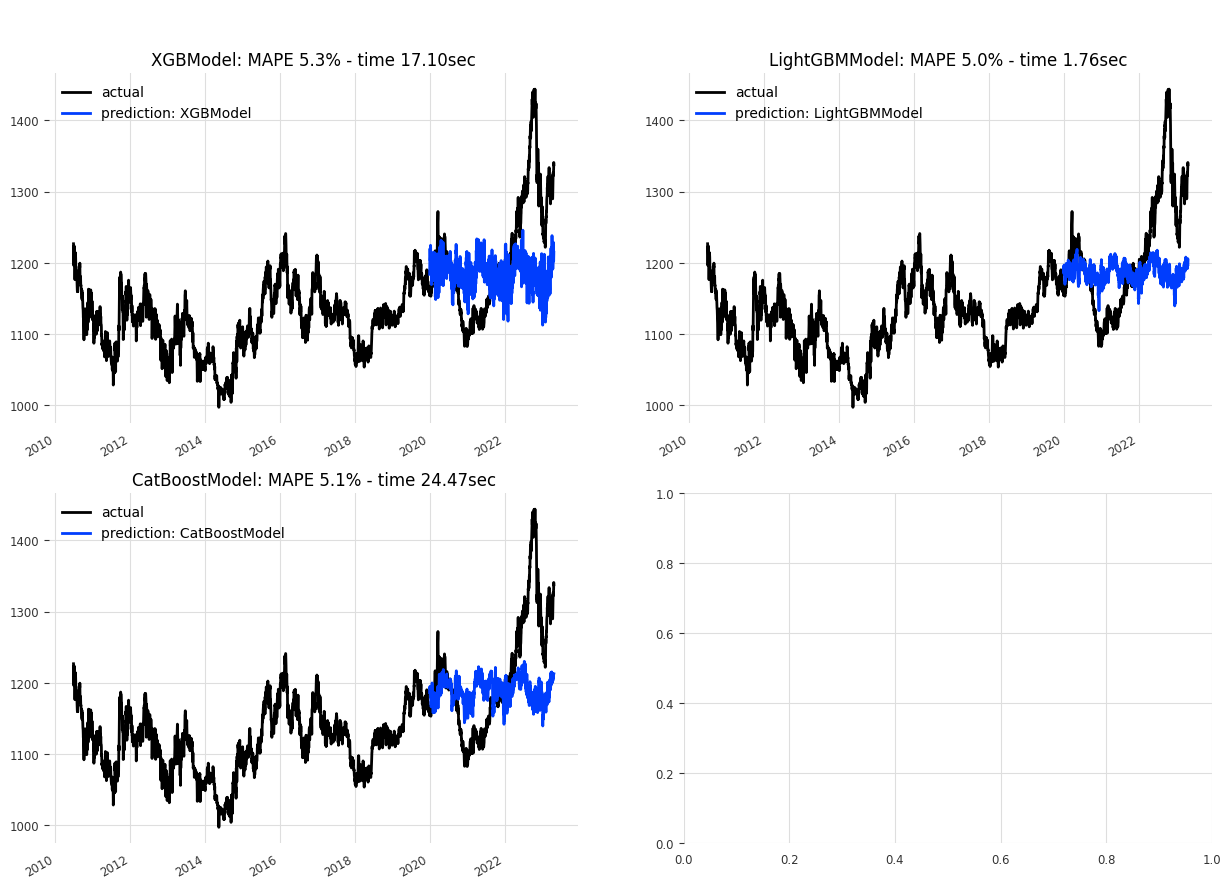

In [ ]:
# plot the forecasts

pairs = math.ceil(len(gra_models)/2)                    # how many rows of charts
fig, ax = plt.subplots(pairs, 2, figsize=(15, 5 * pairs))
ax = ax.ravel()

for i,m in enumerate(gra_models):
        usd_kwon_open.plot(label="actual", ax=ax[i])
        boost_model_predictions[i][0].plot(label="prediction: "+str(m.__class__.__name__), ax=ax[i])
        
        mape_model =  boost_model_predictions[i][1]["MAPE"]
        time_model =  boost_model_predictions[i][1]["time"]
        ax[i].set_title("\n\n" + str(m.__class__.__name__) + ": MAPE {:.1f}%".format(mape_model) + " - time {:.2f}sec".format(time_model))

        ax[i].set_xlabel("")
        ax[i].legend()

**When dont reflect Covariates**

*   Not good result



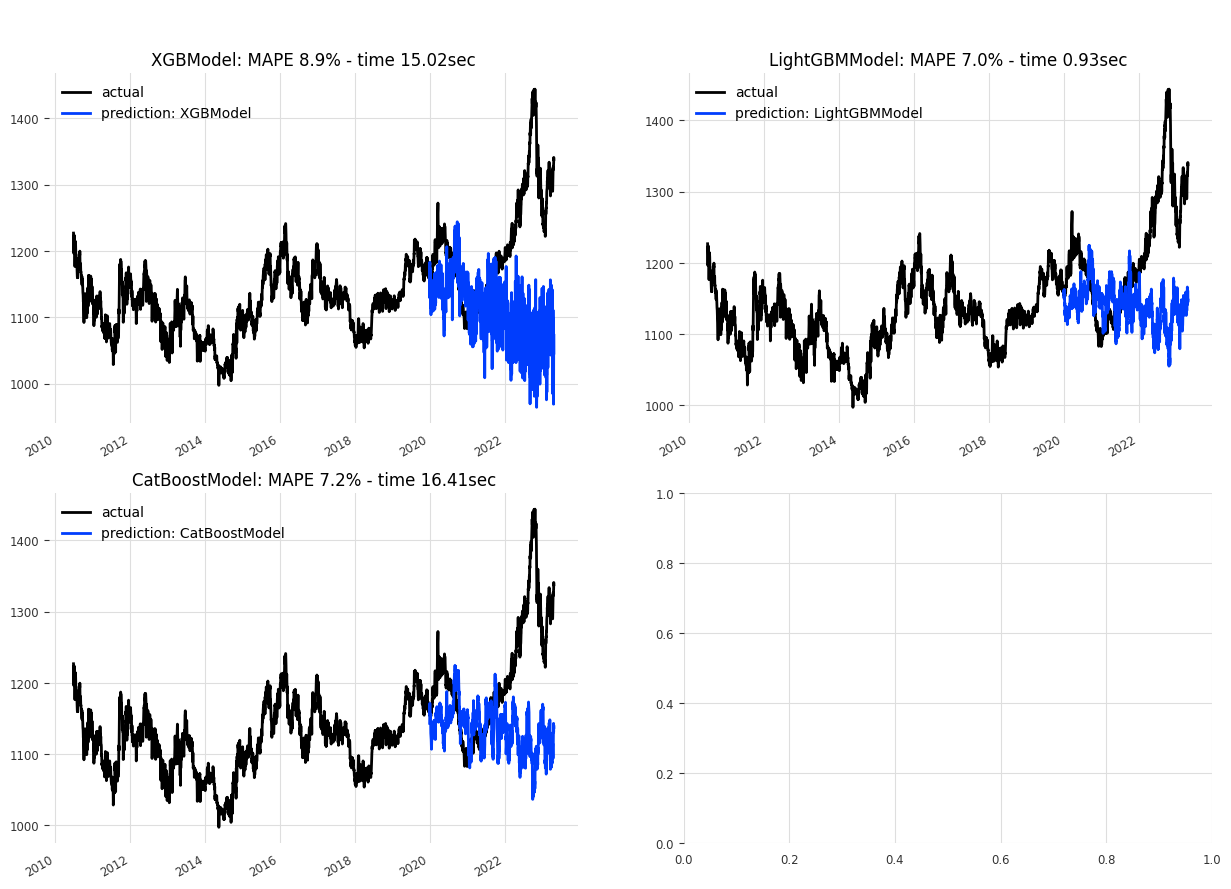

# **Backtesting** : Gradient Boost models

**backtesting** is a process of evaluating the performance of a time series forecasting model on a historical dataset

*   **forecast_horizon** is a parameter used to specify the number of time steps ahead to forecast when making predictions

In [ ]:
start_back = pd.Timestamp('2020-01-02')

In [ ]:
# create empty list to store results
backtest_model_predictions = []

# iterate through models
for gra_model in gra_models:
    
    t_start = time.perf_counter()
    print("beginning: " + str(gra_model))
    
    #Set Backtest for models
    backtest_pred = gra_model.historical_forecasts(
        series_kwon_scaled,
        past_covariates=kwon_past_covariates,
        start=start_back, # (1-len(val_kwon)/len(series_kwon_scaled))
        forecast_horizon=36,
        stride=1,
        retrain=True)
    
    # iverse forcasted scaled values
    inv_backtest_pred = scaler_kwon.inverse_transform(backtest_pred)
    
    # compute accuracy metrics and processing time
    backtest_mape = mape(val, inv_backtest_pred)
    backtest_mae = mae(val, inv_backtest_pred)
    backtest_rmse = rmse(val, inv_backtest_pred)
    backtest_rmsle = rmsle(val, inv_backtest_pred)
    backtest_time = time.perf_counter() - t_start
    backtest_accuracy = {"MAPE":backtest_mape, "MAE":backtest_mae,"RMSE":backtest_rmse, "RMSLE":backtest_rmsle, "time":backtest_time}
    
    # append forecast and accuracy metrics to list of results
    results = [inv_backtest_pred, backtest_accuracy]
    backtest_model_predictions.append(results)
    
    print("completed: " + str(gra_model) + ":" + str(backtest_time) + "sec")


beginning: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)
completed: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,

In [ ]:
#Accuracy of Models
#Green is Best model
#Yellow is Worst model 

backtest_df_acc = pd.DataFrame.from_dict(backtest_model_predictions[0][1], orient="index")
backtest_df_acc.columns = [gra_models[0].__class__.__name__]

for i, m in enumerate(gra_models):
    if i > 0: 
        backtest_df = pd.DataFrame.from_dict(backtest_model_predictions[i][1], orient="index")
        backtest_df.columns = [m.__class__.__name__]
        backtest_df_acc = pd.concat([backtest_df_acc, backtest_df], axis=1)
    i +=1

pd.set_option("display.precision",3)
back_highlight_df = backtest_df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)
display(back_highlight_df)


best_back_model = backtest_df_acc.idxmin(axis=1)["MAPE"]
print("")
print("======================== BEST ACCURACY ========================")
print("Best MAPE model: " + best_back_model)

,XGBModel,LightGBMModel,CatBoostModel
MAPE,2.328803,2.367195,2.565370
MAE,26.999039,27.487855,29.918456
RMSE,36.042182,35.293706,36.165625
RMSLE,0.030842,0.030248,0.030939
time,329.338600,182.155757,7507.210216



======================== BEST ACCURACY ========================
Best MAPE model: XGBModel


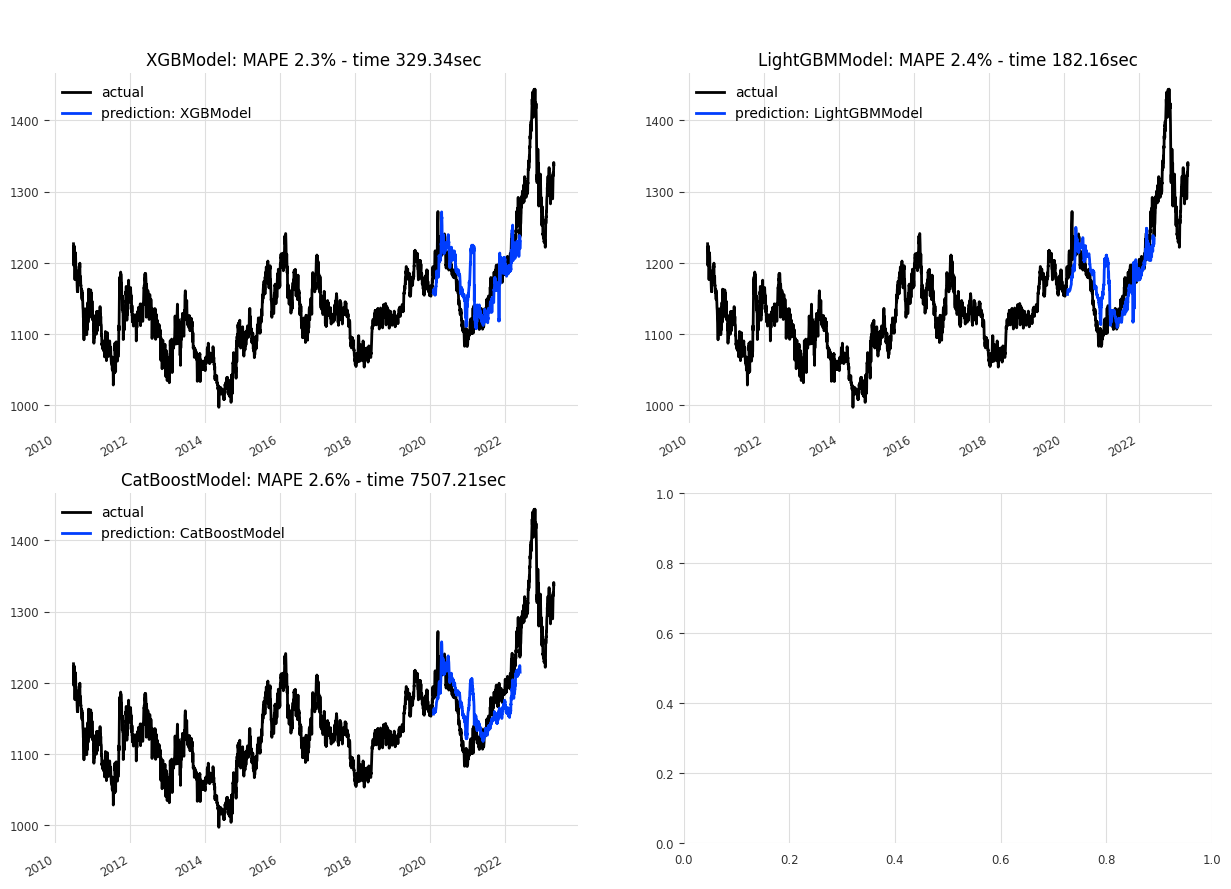

In [ ]:
# plot the forecasts

pairs = math.ceil(len(gra_models)/2)                    # how many rows of charts
fig, ax = plt.subplots(pairs, 2, figsize=(15, 5 * pairs))
ax = ax.ravel()

for i,m in enumerate(gra_models):
        usd_kwon_open.plot(label="actual", ax=ax[i])
        backtest_model_predictions[i][0].plot(label="prediction: "+str(m.__class__.__name__), ax=ax[i])

        mape_model =  backtest_model_predictions[i][1]["MAPE"]
        time_model =  backtest_model_predictions[i][1]["time"]
        ax[i].set_title("\n\n" + str(m.__class__.__name__) + ": MAPE {:.1f}%".format(mape_model) + " - time {:.2f}sec".format(time_model))

        ax[i].set_xlabel("")
        ax[i].legend()

# Definition and Fitting a: Deep Learning Models**


*  N-BEATS
*  LSTM



In [ ]:
## Training with Covariates

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.01 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=50,
    min_delta=0.01,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper]}

In [ ]:
#Model: N-BEATS

model_nbeats = NBEATSModel(
    input_chunk_length=730,
    output_chunk_length=12,
    generic_architecture=True,
    activation = 'ReLU',
    num_blocks=3,
    num_layers=4,
    layer_widths=5,
    dropout= 0.2,
    n_epochs=50,
    nr_epochs_val_period=1,
    batch_size= 50,
    log_tensorboard=True,
    save_checkpoints=True,
    model_name="NBEATS",
    pl_trainer_kwargs={"callbacks": [my_stopper]},
    #pl_trainer_kwargs={
      #"accelerator": "gpu",
      #"devices": [0]
    #},
    force_reset=True
)

#Fit

model_nbeats.fit(mult_train, past_covariates= past_cov, epochs=50, val_series= mult_val, val_past_covariates=past_cov_val, verbose=False);

In [ ]:
# 2.Model: LSTM

model_lstm = BlockRNNModel(
    input_chunk_length=730,
    output_chunk_length=12,
    model="LSTM",
    hidden_dim=5,
    n_rnn_layers=5,
    dropout = 0.2,
    batch_size=50,
    n_epochs=50,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    save_checkpoints=True,
    random_state=0,
    force_reset=True,
    model_name="LSTM",
    pl_trainer_kwargs={"callbacks": [my_stopper]},
    #pl_trainer_kwargs={
      #"accelerator": "gpu",
      #"devices": [0]
    #}
)

#Fit
model_lstm.fit(mult_train, past_covariates= past_cov, epochs=50, val_series= mult_val, val_past_covariates=past_cov_val, verbose=False);

# Prediction


**NBEATS**

In [ ]:
start_date = pd.Timestamp('2018-01-02')
end_date = pd.Timestamp('2023-04-15')
kwon_past_covar = kwon_covariates.slice(start_date, end_date)

Predicting: 0it [00:00, ?it/s]

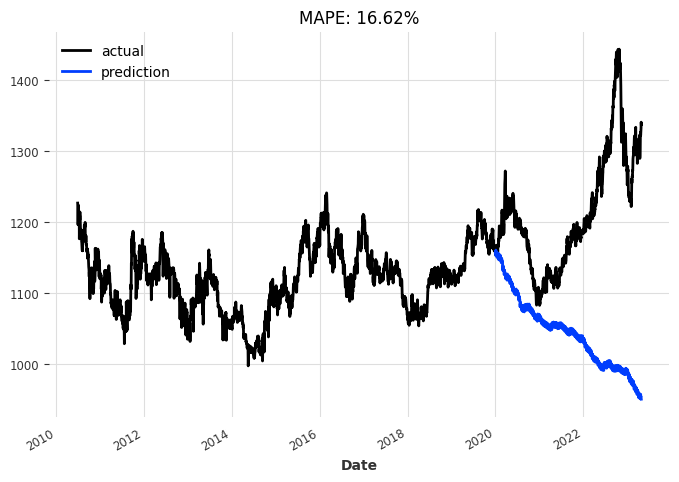

In [ ]:
#predictions on the validation set series : NBEATS
def eval_model(model):
    pred_series = model.predict(n=1212, series=train_kwon, past_covariates=kwon_past_covar)
    inv_pred = scaler_kwon.inverse_transform(pred_series)
    plt.figure(figsize=(8, 5))
    usd_kwon_open.plot(label="actual")
    inv_pred.plot(label="prediction")
    plt.title("MAPE: {:.2f}%".format(mape(inv_pred, val)))
    plt.legend()


eval_model(model_nbeats)

Predicting: 0it [00:00, ?it/s]

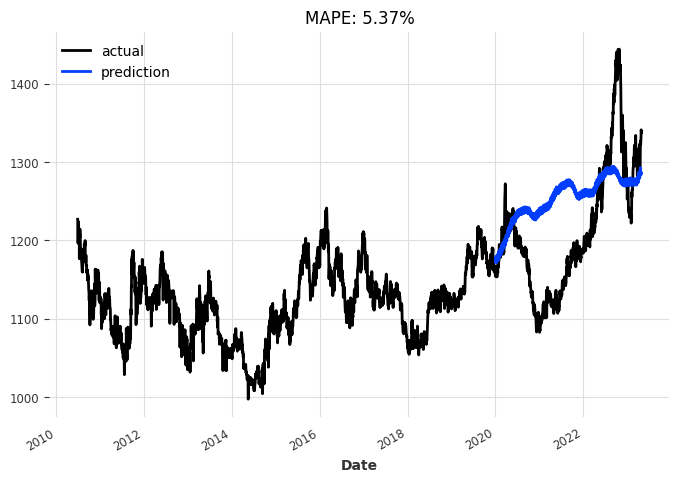

In [ ]:
#Use the best model obtained over training based on validation loss

best_model_nbeats = NBEATSModel.load_from_checkpoint(model_name="NBEATS", best=True)

eval_model(best_model_nbeats)

Predicting: 0it [00:00, ?it/s]

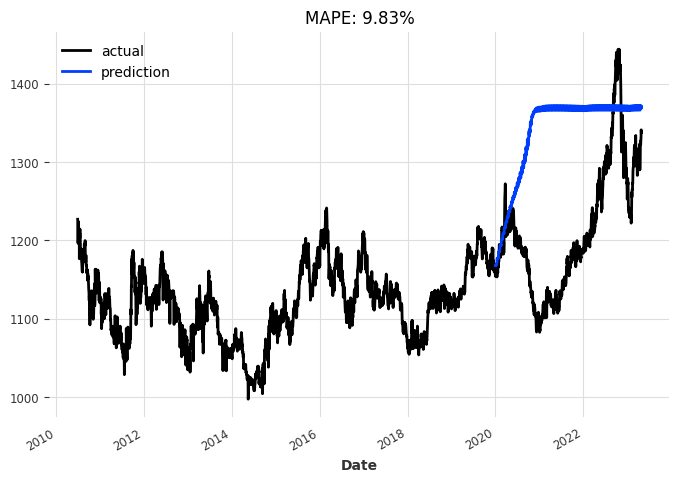

In [ ]:
#predictions on the validation set series: LSTM
def eval_model(model):
    pred_series = model.predict(n=1212, series=train_kwon, past_covariates=kwon_past_covar)
    inv_pred = scaler_kwon.inverse_transform(pred_series)
    plt.figure(figsize=(8, 5))
    usd_kwon_open.plot(label="actual")
    inv_pred.plot(label="prediction")
    plt.title("MAPE: {:.2f}%".format(mape(inv_pred, val)))
    plt.legend()


eval_model(model_lstm)

Predicting: 0it [00:00, ?it/s]

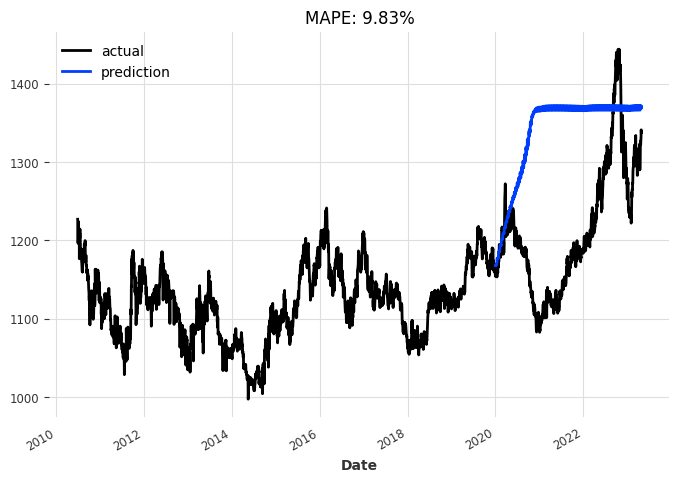

In [ ]:
#Use the best model obtained over training based on validation loss

best_model_lstm = BlockRNNModel.load_from_checkpoint(model_name="LSTM", best=True)

eval_model(best_model_lstm)

# Backtesting

**NBEATS**

In [ ]:
start_date = pd.Timestamp('2018-01-02')
end_date = pd.Timestamp('2023-04-28')
kwon_past_covar = kwon_covariates.slice(start_date, end_date)

In [ ]:
#Backtesting

backtest_nbeats = model_nbeats.historical_forecasts(series_kwon_scaled,
        past_covariates=kwon_past_covar,
        start=start_back, # (1-len(val_kwon)/len(series_kwon_scaled))
        forecast_horizon=36,
        num_samples=1,
        stride=1,
        retrain=False,
        verbose=True)

#inverst values of backtesting

inv_nbeats = scaler_kwon.inverse_transform(backtest_nbeats)

Text(0.5, 1.0, 'MAPE: 3.73%')

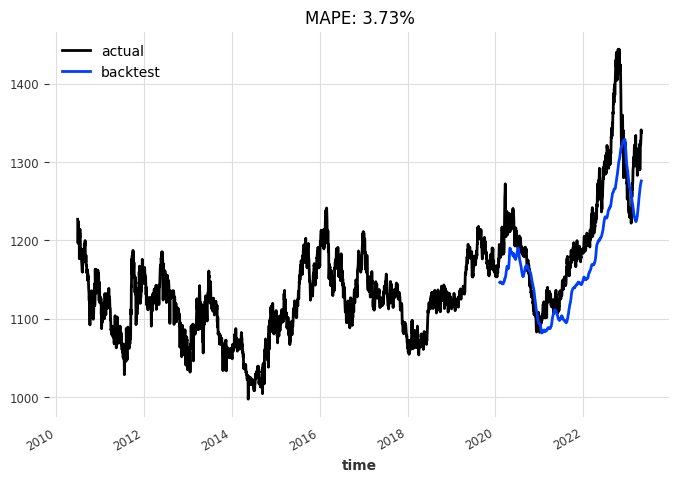

In [ ]:
plt.figure(figsize=(8, 5))
usd_kwon_open.plot(label="actual")
inv_nbeats.plot(label="backtest")
plt.legend()
plt.title("MAPE: {:.2f}%".format(mape(inv_nbeats, val)))

**LSTM**

In [ ]:
#Backtesting

backtest_lstm = model_lstm.historical_forecasts(series_kwon_scaled,
        past_covariates=kwon_past_covar,
        start=start_back, # (1-len(val_kwon)/len(series_kwon_scaled))
        forecast_horizon=36,
        num_samples=1,
        stride=1,
        retrain=False,
        verbose=True)

#inverst values of backtesting

inv_lstm = scaler_kwon.inverse_transform(backtest_lstm)

Text(0.5, 1.0, 'MAPE: 2.68%')

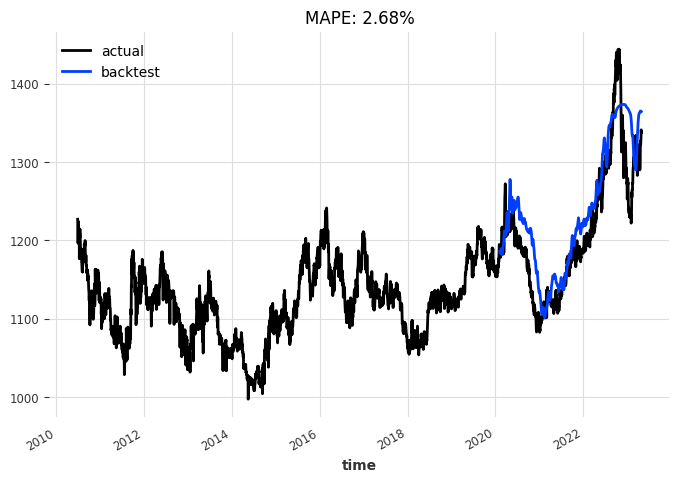

In [ ]:
plt.figure(figsize=(8, 5))
usd_kwon_open.plot(label="actual")
inv_lstm.plot(label="backtest")
plt.legend()
plt.title("MAPE: {:.2f}%".format(mape(inv_lstm, val)))

# **Compare two models** : NBEATS, LSTM

Text(0.5, 0.98, 'NBEATS MAPE: 3.73% - LSTM MAPE: 2.68%')

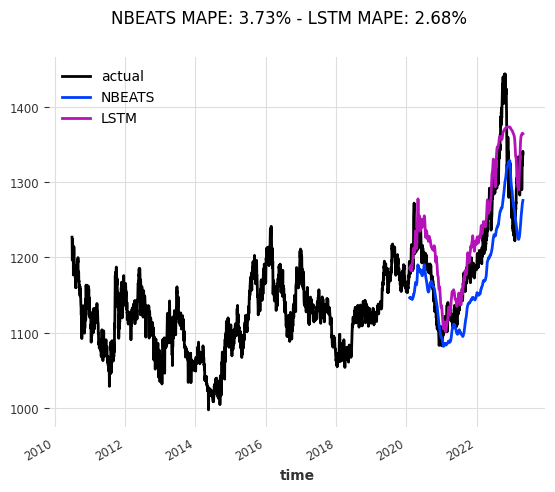

In [ ]:
usd_kwon_open.plot(label="actual")
inv_nbeats.plot(label="NBEATS")
inv_lstm.plot(label="LSTM")
plt.legend()
plt.suptitle("NBEATS MAPE: {:.2f}% - LSTM MAPE: {:.2f}%".format(mape(inv_nbeats, val), mape(inv_lstm, val)))